In [7]:
import pandas as pd
info = pd.read_csv('info.csv', index_col=0)


In [2]:
info.header.value_counts()[:25]

hydrolase                            3326
transferase                          3035
hydrolase/hydrolase inhibitor        2046
transferase/transferase inhibitor    1851
transcription                         672
lyase                                 635
immune system                         459
signaling protein                     443
transport protein                     436
oxidoreductase                        412
ligase                                270
membrane protein                      229
isomerase                             218
chaperone                             217
sugar binding protein                 214
protein binding                       205
lyase/lyase inhibitor                 193
viral protein                         167
cell cycle                            150
ligase/ligase inhibitor               148
transferase/inhibitor                 129
dna binding protein                   116
hydrolase/inhibitor                   104
peptide binding protein           

In [9]:
# assign coarse grained types
info["type"]=""
info.loc[info.header.str.contains("transport"),"type"]="transport"
info.loc[info.header.str.contains("hydrolase"),"type"]="hydrolase"
info.loc[info.header.str.contains("transferase"),"type"]="transferase"
info.loc[info.header.str.contains("transcription"),"type"]="transcription"
info.loc[info.header.str.contains("lyase"),"type"]="lyase"
info.loc[info.header.str.contains("oxidoreductase"),"type"]="oxidoreductase"
info.loc[info.header.str.contains("isomerase"),"type"]="isomerase"
info.loc[info.header.str.contains("ligase"),"type"]="ligase"
info.loc[info.header.str.contains("membrane"),"type"]="membrane"
info.loc[info.header.str.contains("viral"),"type"]="viral"
info.loc[info.header.str.contains("metal"),"type"]="metal_containing"
info.loc[info.header.str.contains("chaperone"),"type"]="chaperone"
info.loc[info.type=="","type"]="other"


In [ ]:
list(info[info.type=="hydrolase"].header.unique())

['hydrolase/hydrolase inhibitor',
 'hydrolase',
 'hydrolase/inhibitor',
 'blood clotting/hydrolase inhibitor',
 'viral protein, hydrolase',
 'hydrolase/antibiotic',
 'hydrolase/hormone',
 'complex (hydrolase/cytidylic acid)',
 'hydrolase(acid protease)',
 'aminohydrolase',
 'hydrolase (acid protease)',
 'hydrolase (endoribonuclease)',
 'hydrolase (alpha-aminoacylpeptide)',
 'blood clotting,hydrolase/inhibitor',
 'hydrolase (acid proteinase)',
 'hydrolase (o-glycosyl)',
 'blood coagulation/hydrolase inhibitor',
 'hydrolase/blood clotting',
 'macro_h2a domain/hydrolase',
 'hydrolase(endoribonuclease)',
 'hydrolase/peptide',
 'serine protease, hydrolase',
 'hydrolase(c-terminal peptidase)',
 'signaling protein, hydrolase',
 'hydrolase(phosphoric diester)',
 'hydrolase(o-glycosyl)',
 'hydrolase(acting in cyclicamidines)',
 'hydrolase(acid proteinase)',
 'hydrolase/hydrolase substrate',
 'de novo protein/hydrolase',
 'blood clotting, hydrolase',
 'fatty acid binding protein/hydrolase',
 'hy

In [ ]:
print(list(info.loc[info.header.str.contains("chaperone"),"header"].unique()))

['chaperone', 'chaperone/inhibitor', 'chaperone/chaperone inhibitor', 'chaperone/peptide binding protein', 'chaperone protein', 'chaperone-binding protein/chaperone', 'isomerase, chaperone', 'chaperone, peptide binding protein', 'chaperone/antibiotic', 'chaperone, hydrolase', 'chaperone/antimicrobial protein', 'chaperone/protein binding', 'histone/chaperone', 'chaperone/chaperone']


In [ ]:
info[info.type==""].header.value_counts()

immune system                 459
signaling protein             443
sugar binding protein         214
protein binding               205
cell cycle                    150
                             ... 
unknown function/inhibitor      1
splicing/signaling protein      1
octopine-binding protein        1
apoptosis activator             1
toxin/toxin inhibitor           1
Name: header, Length: 326, dtype: int64

In [3]:
info.type.value_counts()

hydrolase           5733
transferase         5291
other               3589
transcription        992
lyase                867
transport            621
oxidoreductase       576
ligase               470
isomerase            333
chaperone            300
membrane             284
viral                267
metal_containing     120
Name: type, dtype: int64

<AxesSubplot:ylabel='type'>

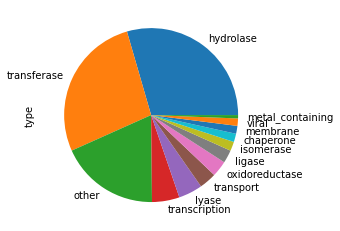

In [4]:
info.type.value_counts().plot.pie()

In [12]:
info

,header,smiles,category,seq,resolution,date,type
6r8o,isomerase,CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...,refined,GNPLVYLDVDANGKPLGRVVLELKADVVPKTAENFRALCTGEKGFG...,1.36,2019-11-27,isomerase
3fh7,hydrolase/hydrolase inhibitor,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,refined,VDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQEDNL...,2.05,2010-01-05,hydrolase
4b7r,hydrolase,CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...,refined,VKLAGNSSLCPVSGWAIYSKDNSVRIGSKGDVFVIREPFISCSPLE...,1.90,2012-10-03,hydrolase
3qfd,immune system,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...,refined,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,1.68,2011-09-28,other
3fvn,membrane protein,[NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...,refined,ANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNIL...,1.50,2010-01-19,membrane
...,...,...,...,...,...,...,...
6npt,transferase,CC(C)(C)c1ccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc...,general,IENCVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAV...,2.19,2019-05-22,transferase
3pax,transferase,COc1cccc(C(N)=O)c1,general,KSKLAKPIQDLIKMIFDVESMKKAMVEFEIDLQKMPLGKLSKRQIQ...,2.40,1998-05-27,transferase
5ezz,hydrolase/inhibitor,Cc1cc([C@@]2(c3cccc(-c4cncc(Cl)c4)c3)COC(=[NH2...,general,RGSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVG...,2.10,2016-02-24,hydrolase
1hgi,viral protein,CO[C@]1(C(=O)[O-])C[C@H](OC(C)=O)[C@@H](NC(C)=...,general,QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSS...,2.70,1994-01-31,viral


# Ligand similarity

In [42]:
import rdkit 
from rdkit import Chem

In [47]:
mols_dict = {}
errors = []
for key,value in info.smiles.items():
    try:
        mols_dict[key] = Chem.MolFromSmiles(value)
    except:
        mols_dict[key] = None
        errors.append(key)
# {key:Chem.MolFromSmiles(value) for key,value in info.smiles.items()}
# info.smiles.to_dict()

[11:59:02] Explicit valence for atom # 34 N, 4, is greater than permitted
[11:59:02] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:59:03] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:59:03] Explicit valence for atom # 3 N, 4, is greater than permitted


In [49]:
len(errors)

322

In [22]:
(info.smiles==np.isnan).sum()

0

In [18]:
info.smiles

6r8o    CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...
3fh7    O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...
4b7r    CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...
3qfd    CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...
3fvn    [NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...
                              ...                        
6npt    CC(C)(C)c1ccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc...
3pax                                   COc1cccc(C(N)=O)c1
5ezz    Cc1cc([C@@]2(c3cccc(-c4cncc(Cl)c4)c3)COC(=[NH2...
1hgi    CO[C@]1(C(=O)[O-])C[C@H](OC(C)=O)[C@@H](NC(C)=...
3e9i    Nc1ncnc2c1ncn2C1OC(COP(=O)(O)ONC(=O)C([NH3+])C...
Name: smiles, Length: 19443, dtype: object

In [37]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit import DataStructs
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load molecular data
smiles = info.smiles
mols = []
valid_indices = []
for idx, smi in zip(info.index, smiles):
    try:
        mol=Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
            valid_indices.append(idx)
    except:
        pass

# Convert molecules to fingerprints
fps=[]
for mol in mols:
    fp=AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
    # array = np.zeros((0, ), dtype=np.int8)
    # DataStructs.ConvertToNumpyArray(fp, array)
    fps.append(fp)


# Calculate similarity matrix
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in tqdm(range(n)):
    for j in range(i+1,n):
        sim=DataStructs.DiceSimilarity(fps[i], fps[j])
        if sim==1: # double check whether molecules are identical
            new_fpsi = AllChem.GetMorganFingerprintAsBitVect(mols[i],4,nBits=1024)
            new_fpsj = AllChem.GetMorganFingerprintAsBitVect(mols[j],4,nBits=1024)
            sim=DataStructs.DiceSimilarity(new_fpsi, new_fpsj)
            if sim==1:
                new_fpsi = AllChem.GetMorganFingerprintAsBitVect(mols[i],10,nBits=1024)
                new_fpsj = AllChem.GetMorganFingerprintAsBitVect(mols[j],10,nBits=1024)
                sim=DataStructs.DiceSimilarity(new_fpsi, new_fpsj)
                if sim==1:
                    if(Chem.MolToSmiles(mols[i])!=Chem.MolToSmiles(mols[j])):
                        sim=0.99
                    # else:
                        # print(i,j,"same molecule")
                        # raise Exception("Stop")

        sim_matrix[i, j] = sim
        sim_matrix[j, i] = sim
    sim_matrix[i, i] = 1



RDKit ERROR: [12:04:06] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:04:06] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [12:04:06] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:04:06] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [12:04:06] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[12:04:06] Explicit valence for atom # 7 Cl, 3, is greater than permitted
RDKit ERROR: [12:04:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:04:07] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [12:04:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:04:07] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [12:04:07] Explicit valence for atom # 6 Br, 3, is greater than permitted
[12:04:07] Explicit valence for atom # 6 Br, 3, is greater than permitted
100%|██████████| 19115/19115 [04:49<00:0

In [11]:
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
CalcMolFormula(mols[50])

'C21H40O4'

In [35]:
Chem.MolToSmiles(mols[0])

'CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)[C@H]1C[C@@H](N2)[C@H](O)CO1'

In [23]:
DataStructs.DiceSimilarity(AllChem.GetMorganFingerprintAsBitVect(mols[16],10,nBits=1024),
AllChem.GetMorganFingerprintAsBitVect(mols[14292],10,nBits=1024))

0.9292035398230089

In [36]:
Chem.MolToSmiles(mols[2500])

'CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)[C@@H]1C[C@H](N2)[C@H](O)CO1'

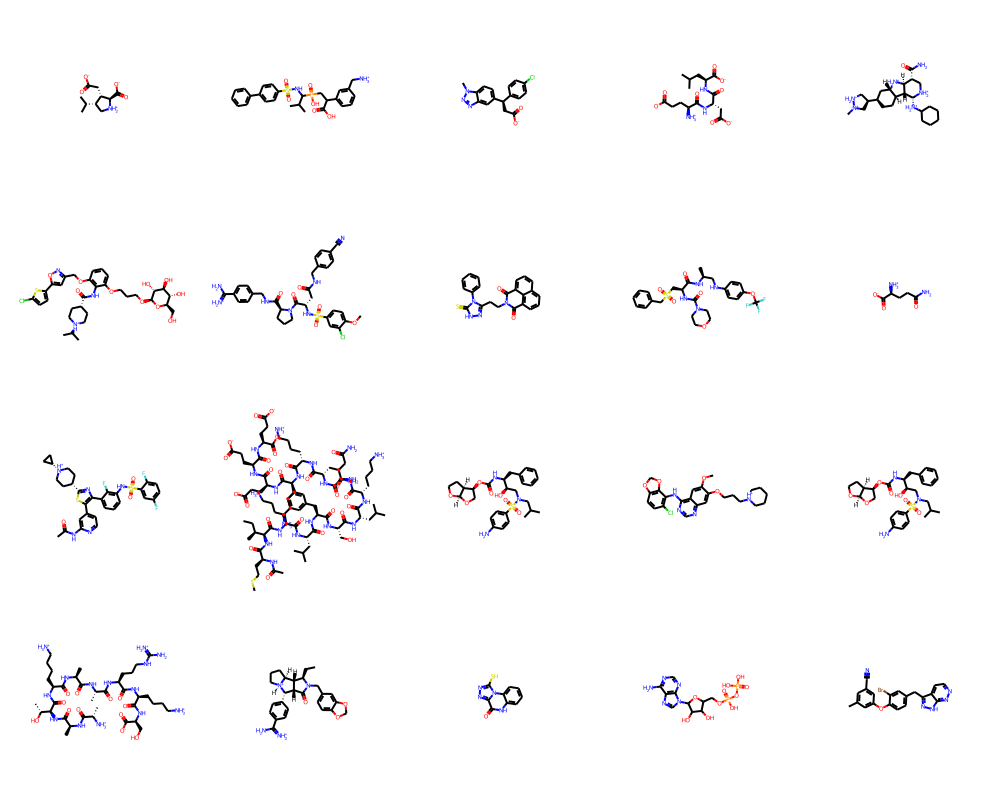

In [115]:
import random
Draw.MolsToGridImage(random.sample(mols,20),molsPerRow=5,subImgSize=(200,200))

In [79]:
from rdkit.Chem import Descriptors
molwt = [Descriptors.MolWt(mol) for mol in mols]
qeds = [Descriptors.qed(mol) for mol in mols]

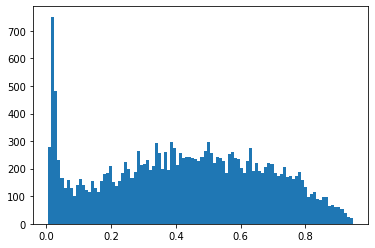

In [83]:
plt.hist(qeds,bins=100);

In [38]:
import pickle
with open("ligand_sim.pkl", "wb") as f:
    pickle.dump((sim_matrix,valid_indices), f)

In [5]:
import pickle
with open("ligand_sim.pkl", "rb") as f:
    sim_matrix, valid_indices = pickle.load(f)

In [39]:
sim_matrix-=np.eye(sim_matrix.shape[0])

(array([3.48058900e+07, 1.75627317e+08, 1.27339344e+08, 2.00999440e+07,
        4.26458400e+06, 1.91334600e+06, 8.73240000e+05, 2.61988000e+05,
        1.01424000e+05, 9.61480000e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

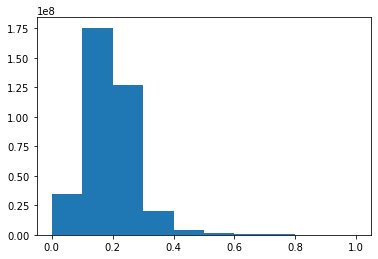

In [40]:
import matplotlib.pyplot as plt
plt.hist(sim_matrix.flatten())

In [99]:
a=(sim_matrix==sim_matrix[(sim_matrix>0.12)].min()).argmax()
x,y=a//sim_matrix.shape[0], a%sim_matrix.shape[0]
print(x,y)

22 18230


In [100]:
print(sim_matrix[x,y])
name_x, name_y = valid_indices[x], valid_indices[y]
print(name_x, name_y)

0.12021857923497267
3rm4 2lp8


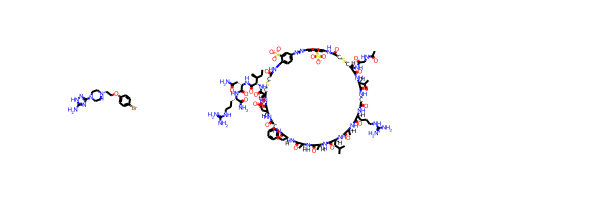

In [101]:
from rdkit.Chem import Draw
from rdkit import Chem
Draw.MolsToGridImage([Chem.MolFromSmiles(info.loc[name_x].smiles),Chem.MolFromSmiles(info.loc[name_y].smiles)])

In [17]:
valid_indices[0], valid_indices[2500]

('6r8o', '6r8l')

In [10]:
import numpy as np
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

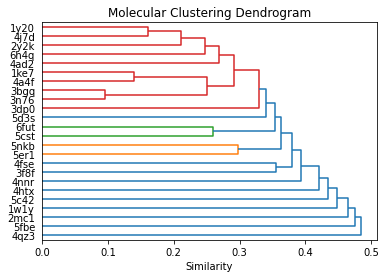

In [75]:
# Perform hierarchical clustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average")
model.fit(sim_matrix)

# Create the counts of samples under each node
counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 # leaf node
        else:
            current_count += counts[child_idx - n_samples] # merged node
    counts[i] = current_count

# Plot dendrogram
plt.title("Molecular Clustering Dendrogram")
linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float) # add two more columns
dendrogram(linkage_matrix, labels=valid_indices, orientation="right")
plt.xlabel("Similarity")
plt.show()

In [81]:
pos = sim_matrix.argmax()
x = pos % len(sim_matrix) # the remainder of dividing pos by width
y = pos // len(sim_matrix)
print(x,y,sim_matrix[x,y])

18 11 0.7341772151898734


In [82]:
valid_indices[x],valid_indices[y]

('2mc1', '4qz3')

In [93]:
valid_indices.index("5er1"),valid_indices.index("4qz3")

(14, 11)

In [94]:
sim_matrix[14,11]

0.6231884057971014

In [51]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load molecular data
sampled=info.sample(25)

mols = []
valid_indices = []
for idx, smi in zip(sampled.index, sampled.smiles):
    try:
        mol=Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
            valid_indices.append(idx)
    except:
        pass

# Convert molecules to fingerprints
fps = [MACCSkeys.GenMACCSKeys(m) for m in mols]

# Calculate similarity matrix
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in tqdm(range(n)):
    for j in range(n):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])



100%|██████████| 24/24 [00:00<00:00, 30878.31it/s]


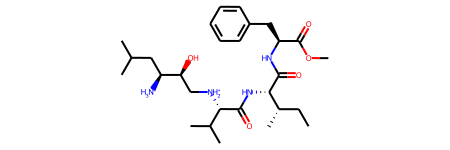

In [91]:
Chem.MolFromSmiles(sampled.loc["5er1"].smiles)

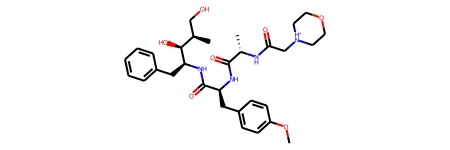

In [92]:
Chem.MolFromSmiles(sampled.loc["4qz3"].smiles)

In [73]:
np.diag(sim_matrix)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [72]:
sim_matrix-np.diag(sim_matrix)

array([[ 0.        , -0.40277778, -0.52542373, -0.69230769, -0.54545455,
        -0.64444444, -0.49206349, -0.74025974, -0.55714286, -0.73611111,
        -0.65277778, -0.45333333, -0.58823529, -0.57647059, -0.52941176,
        -0.63953488, -0.66666667, -0.5443038 , -0.51190476, -0.45205479,
        -0.62244898, -0.65060241, -0.68604651, -0.65079365],
       [-0.40277778,  0.        , -0.55882353, -0.68493151, -0.48148148,
        -0.61458333, -0.48571429, -0.74418605, -0.42253521, -0.70886076,
        -0.71428571, -0.30666667, -0.61038961, -0.53333333, -0.45833333,
        -0.59340659, -0.77941176, -0.48192771, -0.4       , -0.45      ,
        -0.54      , -0.5862069 , -0.60674157, -0.68493151],
       [-0.52542373, -0.55882353,  0.        , -0.80701754, -0.68055556,
        -0.77906977, -0.5       , -0.90410959, -0.6875    , -0.74576271,
        -0.73015873, -0.625     , -0.63793103, -0.64935065, -0.63934426,
        -0.73417722, -0.75      , -0.71052632, -0.61538462, -0.7027027 ,
  

In [58]:
from rdkit.Chem import AllChem
from scipy.cluster.hierarchy import dendrogram , linkage
from scipy.spatial.distance import pdist

fps_site1=[]
for i in range(len(sampled)):
    try:
        s=Chem.MolFromSmiles(sampled.iloc[i]["smiles"])
        fp=AllChem.GetMorganFingerprintAsBitVect(s,2,nBits=1024)
        array = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        fps_site1.append(array)
    except:
        pass
fps_site1=np.array(fps_site1)

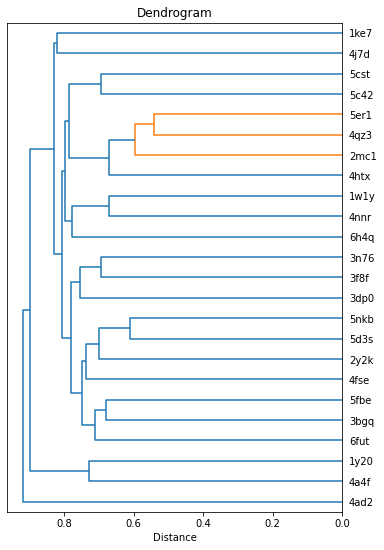

In [60]:
Z = linkage(fps_site1, method = 'weighted',metric="dice")
plt.figure(figsize=(6,9))
dendro = dendrogram(Z,color_threshold=0.6,orientation="left",labels=valid_indices)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()

# protein similarity

In [1]:
from Bio import Align
from Bio.SubsMat import MatrixInfo as matlist
import numpy as np
from tqdm import tqdm

def Needleman_Wunsch_alignment(seq1,seq2):
    '''
    Function for doing global alignment between seq1 and seq2 using Needleman-Wunsch algorithm implemented in Biopython
    '''
    missing=None
    if "-" in seq1:
        # Need to handle "-" beforehand, otherwise the alignment may fail
        missing=[s=="-" for s in seq1]
        seq1=seq1.replace("-","")
    aligner=Align.PairwiseAligner()
    aligner.open_gap_score=-10
    aligner.extend_gap_score=-0.5
    aligner.substitution_matrix=matlist.blosum62
    alignment=aligner.align(seq1,seq2)[0]
    alignment_info=alignment.__str__().split("\n")
    aligned1,aligned2=alignment_info[0],alignment_info[2]
    if missing is None:
        final1=aligned1
        final2=aligned2
    else:
        # Assign alignment with "-"
        final1_temp=""
        final2_temp=""
        j=0
        for s in missing:
            if s:
                final1_temp+="-"
                final2_temp+="-"
            else:
                while aligned1[j]=="-" and j<len(aligned1):
                    final1_temp+=aligned1[j]
                    final2_temp+=aligned2[j]
                    j+=1
                if j<len(aligned1):
                    final1_temp+=aligned1[j]
                    final2_temp+=aligned2[j]
                    j+=1
        if j<len(aligned1):
            final1_temp+=aligned1[j:]
            final2_temp+=aligned2[j:]
        # Cleaning up
        final1=""
        final2=""
        for i in range(len(final1_temp)):
            if not (final1_temp[i]=="-" and final2_temp[i]=="-"):
                final1+=final1_temp[i]
                final2+=final2_temp[i]
    return final1,final2

In [2]:
class Align_result:
    def __init__(self,pdbid=None):
        self.target_name=pdbid
        self.rmsd=0
        self.TMscore=0
        self.source_seq=""
        self.target_seq=""
        self.coverage=0
    
    def parse_alignment(self,source_seq, target_seq):
        '''
        Function to parse the alignment generated by mTM-align (multiple sequences alignment) to the alignments between two
        '''
        assert len(source_seq)==len(target_seq)
        for i in range(len(source_seq)):
            if source_seq[i]=="-" and target_seq[i]=="-":
                continue
            else:
                self.source_seq+=source_seq[i]
                self.target_seq+=target_seq[i]
        self.coverage=len([i for i in range(len(self.source_seq)) if self.source_seq[i]==self.target_seq[i]])/len(self.source_seq)

In [5]:
# Import the pairwise2 module from Biopython
from Bio import pairwise2

# Define two protein sequences as strings
seq1 = "QSGPVIRVAGDSTAVGEGGRWMKEMVEAWGKKTGTRVEYIDSPADTNDRLALYQQYWAARSPDVDVYMIDVIWPGIVAPHALDLKPYLTEAELKEFFPRIVQNNTIRGKLTSLPFFTDAGILYYRKDLLEKYGYTSPPRTWNELEQMAERVMEGERRAGNRDFWGFVFQGKPYEGLTCDALEWIYSHGGGRIVEPDGTISVNNGRAALALNRAHGWVGRIAPQGVTSYAEEEARNVWQQGNSLFMRNWPYAYALGQAEGSPIRGKFGVTVLPKASADAPNAATLGGWQLMVSAYSRYPKEAVDLVKYLASYEVQKDNAVRLSRLPTRPALYTDRDVLARNPWFRDLLPVFQNAVSRPSDVAGARYNQVSEAIWTEVHSVLTGRKKGEQAVRDLEARIRRILRHHHHHH"
seq2 = "MKITVWTHFGGPELEWLKEQARTFERTSGTKVEVVEVPFAEIKQKFILGAPQGQAADLVVTVPHDWVGEMAQAGVLEPVGKYVTQAYLADLQGVAVEAFTFGGRLMGLPAFAESVALIYNKKYVKEPPRTWEEFLALAQKLTTGATFGFLYNIGDPYFNFGFFKAFGAENVFAKDAKGNLDPTKLLIGGEVGEKALQFIKDLRFKYNLVPEGVDYGVADGAFKDGALAMILNGPWALGDYKKAKVDFGIAPFPVPPGAKNPWGPFLGVQGVVVNAYSKNKTQAVNFAKTLVTGRNLVAFNQAGGRIPVSKSAVKQLEKDPVVAGFSKVFPLGAPMPNIPEMGKVWGPWGNAISLAIQRPDSNVKKIVEDMVAEIKKAIGRHHHHHH"

# Perform global alignment using the BLOSUM62 scoring matrix
result=Align_result()
aseq1,aseq2=Needleman_Wunsch_alignment(seq1,seq2)
result.parse_alignment(aseq1,aseq2)
print(result.coverage)

0.2420814479638009


In [12]:
info.type.value_counts()

hydrolase           5733
transferase         5291
other               3589
transcription        992
lyase                867
transport            621
oxidoreductase       576
ligase               470
isomerase            333
chaperone            300
membrane             284
viral                267
metal_containing     120
Name: type, dtype: int64

In [13]:
ligase_proteins=info[info.type=="ligase"]

In [21]:
n=len(ligase_proteins)

sim_matrix = np.zeros((n, n))
all_comparisons = [(i,j) for i in range(n) for j in range(i + 1, n)]
for i,j in tqdm(all_comparisons):
    result=Align_result()
    aseq1,aseq2=Needleman_Wunsch_alignment(ligase_proteins.iloc[i].seq,ligase_proteins.iloc[j].seq)
    result.parse_alignment(aseq1,aseq2)
    sim_matrix[i, j] = result.coverage

100%|██████████| 110215/110215 [06:57<00:00, 264.19it/s]


In [24]:
import pickle
with open("protein_seq_sim.pkl","wb") as f:
    pickle.dump({"ligase": sim_matrix},f)
# sim_matrix

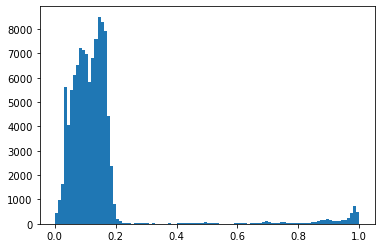

In [29]:
import matplotlib.pyplot as plt
plt.hist(sim_matrix[sim_matrix>0],bins=100);

In [35]:
a=(sim_matrix==sim_matrix[(sim_matrix>0.85)].min()).argmax()
x,y=a//sim_matrix.shape[0], a%sim_matrix.shape[0]
print(sim_matrix[x,y])
print(x,y)

0.8500881834215167
7 90


In [34]:
print(ligase_proteins.index[x],ligase_proteins.index[y])

4muf 3ioe


In [37]:
ligase_proteins.loc["4muf"].seq

'PAFHPGELNVYSAPGDVADVSRALRLTGRRVMLVPTMGALHEGHLALVRAAKRVPGSVVVVSIFVNPMQAYPRTPDDDLAQLRAEGVEIAFTPTTAAMYPDGLRTTVQPGPLAAELEGGPRPTHFAGVLTVVLKLLQIVRPDRVFFGEKDYQQLVLIRQLVADFNLDVAVVGVPTVREADGLAMSSRNRYLDPAQRAAAVALSAALTAAAHAATAGAQAALDAARAVLDAAPGVAVDYLELRDIGLGPMPLNGSGRLLVAARLGTTRLLDNIAIEIGT:AIPAFHPGELNVYSAPGDVADVSRALRLTGRRVMLVPTMGALHEGHLALVRAAKRVPGSVVVVSIFVNPPDDDLAQLRAEGVEIAFTPTTAAMYPDGLRTTVQPGPLAAELEGGPRPTHFAGVLTVVLKLLQIVRPDRVFFGEKDYQQLVLIRQLVADFNLDVAVVGVPTVREADGLAMSSRNRYLDPAQRAAAVALSAALTAAAHAATAGAQAALDAARAVLDAAPGVAVDYLELRDIGLGPMPLNGSGRLLVAARLGTTRLLDNIAIEIG'

In [38]:
ligase_proteins.loc["3ioe"].seq

'PAFHPGELNVYSAPGDVADVSRALRLTGRRVMLVPTMGALHEGHLALVRAAKRVPGSVVVVSIFVNPMQFGAGGDLDAYPRTPDDDLAQLRAEGVEIAFTPTTAAMYPDGLRTTVQPGPLAAELEGGPRPTHFAGVLTVVLKLLQIVRPDRVFFGEKDYQQLVLIRQLVADFNLDVAVVGVPTVREADGLAMSSRNRYLDPAQRAAAVALSAALTAAAHAATAGAQAALDAARAVLDAAPGVAVDYLELRDIGLGPMPLNGSGRLLVAARLGTTRLLDNIAIEIGT:AIPAFHPGELNVYSAPGDVADVSRALRLTGRRVMLVPTMGALHEGHLALVRAAKRVPGSVVVVSIFVNPMQFAYPRTPDDDLAQLRAEGVEIAFTPTTAAMYPDGLRTTVQPGPLAAELEGGPRPTHFAGVLTVVLKLLQIVRPDRVFFGEKDYQQLVLIRQLVADFNLDVAVVGVPTVREADGLAMSSRNRYLDPAQRAAAVALSAALTAAAHAATAGAQAALDAARAVLDAAPGVAVDYLELRDIGLGPMPLNGSGRLLVAARLGTTRLLDNIAIEIG'

In [39]:
info.to_csv("info_with_type.csv")

In [19]:
ligase_proteins.iloc[i]

header                                  ligase/ligase inhibitor
smiles        Nc1ncnc2c1ncn2[C@@H]1O[C@H](CNS(=O)(=O)NC(=O)C...
category                                                refined
seq           DRDRLRPPLDERSLRDQLIGAGSGWRQLDVVAQTGSTNADLLARAA...
resolution                                                 1.85
date                                                 2015-09-02
type                                                     ligase
Name: 4xu2, dtype: object

In [118]:
matlist.blosum62

{('W', 'F'): 1,
 ('L', 'R'): -2,
 ('S', 'P'): -1,
 ('V', 'T'): 0,
 ('Q', 'Q'): 5,
 ('N', 'A'): -2,
 ('Z', 'Y'): -2,
 ('W', 'R'): -3,
 ('Q', 'A'): -1,
 ('S', 'D'): 0,
 ('H', 'H'): 8,
 ('S', 'H'): -1,
 ('H', 'D'): -1,
 ('L', 'N'): -3,
 ('W', 'A'): -3,
 ('Y', 'M'): -1,
 ('G', 'R'): -2,
 ('Y', 'I'): -1,
 ('Y', 'E'): -2,
 ('B', 'Y'): -3,
 ('Y', 'A'): -2,
 ('V', 'D'): -3,
 ('B', 'S'): 0,
 ('Y', 'Y'): 7,
 ('G', 'N'): 0,
 ('E', 'C'): -4,
 ('Y', 'Q'): -1,
 ('Z', 'Z'): 4,
 ('V', 'A'): 0,
 ('C', 'C'): 9,
 ('M', 'R'): -1,
 ('V', 'E'): -2,
 ('T', 'N'): 0,
 ('P', 'P'): 7,
 ('V', 'I'): 3,
 ('V', 'S'): -2,
 ('Z', 'P'): -1,
 ('V', 'M'): 1,
 ('T', 'F'): -2,
 ('V', 'Q'): -2,
 ('K', 'K'): 5,
 ('P', 'D'): -1,
 ('I', 'H'): -3,
 ('I', 'D'): -3,
 ('T', 'R'): -1,
 ('P', 'L'): -3,
 ('K', 'G'): -2,
 ('M', 'N'): -2,
 ('P', 'H'): -2,
 ('F', 'Q'): -3,
 ('Z', 'G'): -2,
 ('X', 'L'): -1,
 ('T', 'M'): -1,
 ('Z', 'C'): -3,
 ('X', 'H'): -1,
 ('D', 'R'): -2,
 ('B', 'W'): -4,
 ('X', 'D'): -1,
 ('Z', 'K'): 1,
 ('F', 'A'): -